Time Series Analysis for Dynamical Systems


# 1. Problem Definition: Short Term Load Forecasting

Load forecasting within the context of energy demand. It is an open-access data published as the appendix Hong et al. (2016). The data consists of three years of hourly electricity load and temperatures.


# 2. Preparing the environment

Import the Python libraries that we will need to (i) load the data, (ii) analyze it, (iii) create our model, (iv) process the results.

In [35]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.53 s (started: 2024-09-13 12:58:12 +02:00)



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Libraries

In [36]:
#Local Installations
!pip install statsmodels

time: 1.5 s (started: 2024-09-13 12:58:13 +02:00)



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import datetime as dt
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import statsmodels.api as sm
import warnings
import matplotlib.dates as mdates
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

time: 0 ns (started: 2024-09-13 12:58:15 +02:00)


In [38]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm

time: 0 ns (started: 2024-09-13 12:58:15 +02:00)


In [39]:
# ML Algorithms to be used
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR

time: 0 ns (started: 2024-09-13 12:58:15 +02:00)


In [40]:
# ML Algorithms to be used
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR

time: 0 ns (started: 2024-09-13 12:58:15 +02:00)


# 3. Pre-processing


In [41]:
cwd = os.getcwd()
DATA_PATH = os.path.join(cwd, '..', 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
def read_Data():
    data_path = os.path.join(RAW_DATA_PATH, "energy.csv") #,parse_dates=[['Date', 'Hour']]) if date and hour to be merged here.
    data = pd.read_csv(data_path)
    return data

time: 0 ns (started: 2024-09-13 12:58:15 +02:00)


In [42]:
data = read_Data()
data.head()

,Date,Hour,load,T
0,01/01/2004,1,NaN,37.33
1,01/01/2004,2,NaN,37.67
2,01/01/2004,3,NaN,37.00
3,01/01/2004,4,NaN,36.33
4,01/01/2004,5,NaN,36.00


time: 31 ms (started: 2024-09-13 12:58:15 +02:00)


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96432 entries, 0 to 96431
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    96432 non-null  object 
 1   Hour    96432 non-null  int64  
 2   load    78888 non-null  float64
 3   T       96432 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.9+ MB
time: 0 ns (started: 2024-09-13 12:58:15 +02:00)


In [44]:
#If you look at the the data, you will see that we do not have any load data for the first two years.
#We need to drop the NaN values to remove these rows:
data = data.dropna() 

time: 16 ms (started: 2024-09-13 12:58:15 +02:00)


In [45]:
#Lets see:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78888 entries, 17544 to 96431
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    78888 non-null  object 
 1   Hour    78888 non-null  int64  
 2   load    78888 non-null  float64
 3   T       78888 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.0+ MB
time: 15 ms (started: 2024-09-13 12:58:15 +02:00)


In [46]:
#But the time information is currently a string (see also above). We need to change it.
#Lets see what pandas offers for that purpose!
data.sample(4)

,Date,Hour,load,T
76158,08/09/2012,7,2872.0,70.33
93307,23/08/2014,20,3469.0,69.67
35828,01/02/2008,21,3835.0,30.33
38835,06/06/2008,4,2272.0,57.67


time: 0 ns (started: 2024-09-13 12:58:15 +02:00)


### Modifying the time information in our data

Here we will use the string column Data and Hour to create timestamp indices. 

In [47]:
#Let's see the data indices:
data.iloc[23]

Date    01/01/2006
Hour            24
load        2985.0
T            24.33
Name: 17567, dtype: object

time: 0 ns (started: 2024-09-13 12:58:15 +02:00)


In [48]:
data.loc[data.Hour == 24, "Hour"] = 0
data.iloc[23]

Date    01/01/2006
Hour             0
load        2985.0
T            24.33
Name: 17567, dtype: object

time: 0 ns (started: 2024-09-13 12:58:15 +02:00)


In [49]:
#Converting time hour into string:
data['Hour']= data['Hour'].apply(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78888 entries, 17544 to 96431
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    78888 non-null  object 
 1   Hour    78888 non-null  object 
 2   load    78888 non-null  float64
 3   T       78888 non-null  float64
dtypes: float64(2), object(2)
memory usage: 3.0+ MB
time: 15 ms (started: 2024-09-13 12:58:15 +02:00)


In [50]:
data.head()

,Date,Hour,load,T
17544,01/01/2006,1,3010.0,22.67
17545,01/01/2006,2,2853.0,20.67
17546,01/01/2006,3,2758.0,21.33
17547,01/01/2006,4,2705.0,19.00
17548,01/01/2006,5,2709.0,19.33


time: 16 ms (started: 2024-09-13 12:58:15 +02:00)


In [51]:
#Merging Columns:
data['Date']= data['Date']+' '+ data['Hour']
data = data.drop(['Hour'],axis=1)
data.head(2)

,Date,load,T
17544,01/01/2006 1,3010.0,22.67
17545,01/01/2006 2,2853.0,20.67


time: 16 ms (started: 2024-09-13 12:58:15 +02:00)


In [52]:
# convert the column to datetime type:
datetime_series = pd.to_datetime(data['Date'],format='%d/%m/%Y %H')
datetime_series.head()

17544   2006-01-01 01:00:00
17545   2006-01-01 02:00:00
17546   2006-01-01 03:00:00
17547   2006-01-01 04:00:00
17548   2006-01-01 05:00:00
Name: Date, dtype: datetime64[ns]

time: 125 ms (started: 2024-09-13 12:58:15 +02:00)


In [53]:
#Create datetime index and pass it:
datetime_index = pd.DatetimeIndex(datetime_series.values)
#Updating the indices:
data=(data.set_index(datetime_index)).drop(['Date'],axis=1)
data.head(3)

,load,T
2006-01-01 01:00:00,3010.0,22.67
2006-01-01 02:00:00,2853.0,20.67
2006-01-01 03:00:00,2758.0,21.33


time: 0 ns (started: 2024-09-13 12:58:15 +02:00)


But there is still an issue in the data, that is '00' comes after '23'. We need to sort indices. 

In [54]:
data = data.sort_index()
data.to_csv(os.path.join(DATA_PATH, 'interim', 'energy_preprocessed.csv'))

time: 156 ms (started: 2024-09-13 12:58:15 +02:00)


## Exploring the Data

Now we have the time as indices, we can filter the time zones of interest and analyze the data as we wish. 

In [21]:
# Filter data by a specific date:
filtered_data = data.loc['2012-1-5']
print(filtered_data)

                       load      T
2012-01-05 00:00:00  3167.0  19.00
2012-01-05 01:00:00  3014.0  22.33
2012-01-05 02:00:00  2921.0  22.33
2012-01-05 03:00:00  2874.0  22.00
2012-01-05 04:00:00  2876.0  21.67
2012-01-05 05:00:00  2962.0  21.33
2012-01-05 06:00:00  3239.0  21.33
2012-01-05 07:00:00  3719.0  21.67
2012-01-05 08:00:00  3940.0  22.67
2012-01-05 09:00:00  3933.0  23.00
2012-01-05 10:00:00  3948.0  24.00
2012-01-05 11:00:00  3945.0  25.67
2012-01-05 12:00:00  3933.0  28.00
2012-01-05 13:00:00  3894.0  29.33
2012-01-05 14:00:00  3873.0  30.67
2012-01-05 15:00:00  3838.0  32.00
2012-01-05 16:00:00  3855.0  32.00
2012-01-05 17:00:00  4112.0  30.67
2012-01-05 18:00:00  4326.0  29.00
2012-01-05 19:00:00  4317.0  27.00
2012-01-05 20:00:00  4213.0  25.00
2012-01-05 21:00:00  4031.0  24.00
2012-01-05 22:00:00  3749.0  22.33
2012-01-05 23:00:00  3417.0  20.00
time: 0 ns (started: 2024-09-13 12:55:02 +02:00)


There is also another function that you can use with time series data sets called `truncate()`.

In [22]:
data.truncate(before='2012-11-01', after='2012-11-02')

,load,T
2012-11-01 00:00:00,2607.0,46.00
2012-11-01 01:00:00,2386.0,48.00
2012-11-01 02:00:00,2311.0,47.67
2012-11-01 03:00:00,2264.0,47.00
2012-11-01 04:00:00,2267.0,46.00
2012-11-01 05:00:00,2352.0,45.67
2012-11-01 06:00:00,2622.0,45.33
2012-11-01 07:00:00,3108.0,44.67
2012-11-01 08:00:00,3371.0,45.67
2012-11-01 09:00:00,3405.0,46.00


time: 16 ms (started: 2024-09-13 12:55:02 +02:00)


### Checking for NaN values and Types

You should check for NaN values after playing with data:

In [23]:
data.isna().sum()

load    0
T       0
dtype: int64

time: 0 ns (started: 2024-09-13 12:55:02 +02:00)


In [24]:
data.dtypes

load    float64
T       float64
dtype: object

time: 0 ns (started: 2024-09-13 12:55:02 +02:00)


### Statistics
Let's look at some simple statistics:

In [25]:
data.describe()

,load,T
count,78888.000000,78888.000000
mean,3308.000837,47.573934
std,579.803021,19.201314
min,1811.000000,-18.000000
25%,2845.000000,32.670000
50%,3382.000000,48.670000
75%,3709.000000,63.000000
max,5506.000000,97.000000


time: 16 ms (started: 2024-09-13 12:55:02 +02:00)


### Data Analysis with Custom Frequency

In [26]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.tseries.offsets.DateOffset.html
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.asfreq.html
# For business days only:
data_custom = data.asfreq(pd.offsets.BDay(), method='pad') #Method to use for filling holes in reindexed Series 
data_custom.head(10)

,load,T
2006-01-02,2913.0,29.00
2006-01-03,3121.0,17.67
2006-01-04,3053.0,27.33
2006-01-05,3012.0,29.00
2006-01-06,3098.0,23.33
2006-01-09,2964.0,33.00
2006-01-10,2986.0,27.00
2006-01-11,2842.0,41.67
2006-01-12,2845.0,31.00
2006-01-13,2800.0,44.67


time: 31 ms (started: 2024-09-13 12:55:02 +02:00)


### Exploring time-related information

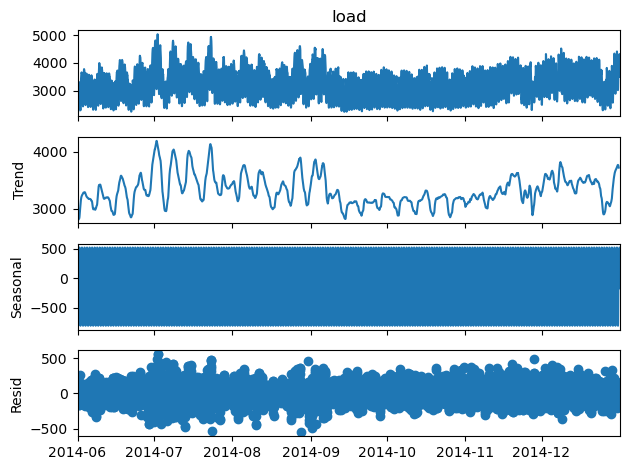

time: 687 ms (started: 2024-09-13 12:55:02 +02:00)


In [27]:
#taking load column:
data_load = data['load']
#Calling our function:
decomposition = sm.tsa.seasonal_decompose(data_load['2014-06-01':'2014-12-31'], model = 'additive')
#Plotting:
fig = decomposition.plot()
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

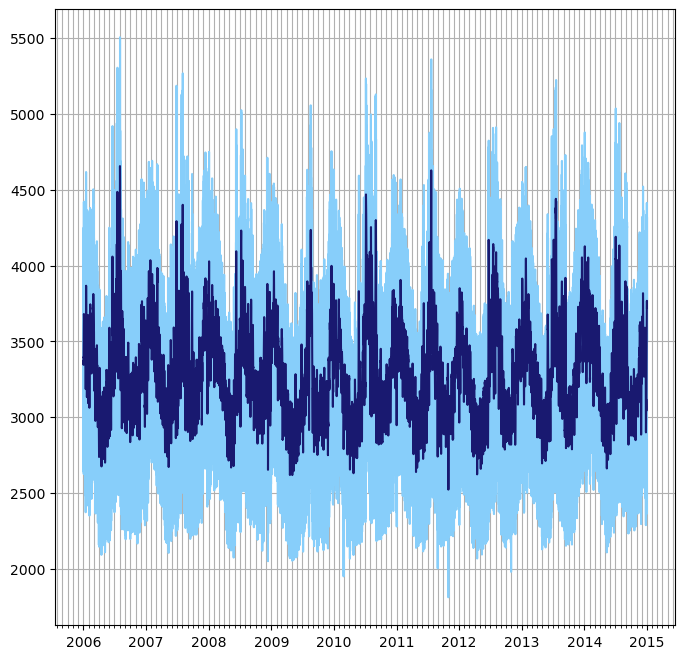

time: 1 s (started: 2024-09-13 12:55:03 +02:00)


In [28]:
#Calling function:
decomposition = sm.tsa.seasonal_decompose(data_load, model = 'additive')
#Plotting:
fig, ax = plt.subplots()
ax.grid(True)
#Matplotlib’s YearLocator() makes ticks on a given day of each year that is a multiple of base:
year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=1)
year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%m')
ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which = 'minor')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)
plt.plot(data_load.index, data_load, c=colors['lightskyblue'])
plt.plot(decomposition.trend.index, decomposition.trend, c=colors['midnightblue'])
mpl.rcParams['figure.figsize'] = [18.0, 6.0]

### Normalization / Standardization in Time Series

In [29]:
#Looking into the statistics:
data.describe()

,load,T
count,78888.000000,78888.000000
mean,3308.000837,47.573934
std,579.803021,19.201314
min,1811.000000,-18.000000
25%,2845.000000,32.670000
50%,3382.000000,48.670000
75%,3709.000000,63.000000
max,5506.000000,97.000000


time: 16 ms (started: 2024-09-13 12:55:04 +02:00)


In [30]:
#Rescaling the data
featuresToScale = data.columns
sX = pp.StandardScaler(copy=True)
data.loc[:,featuresToScale] = sX.fit_transform(data[featuresToScale])
#Looking into the statistics again:
data.describe()

,load,T
count,7.888800e+04,7.888800e+04
mean,3.127224e-16,8.646702e-17
std,1.000006e+00,1.000006e+00
min,-2.581929e+00,-3.415097e+00
25%,-7.985536e-01,-7.761984e-01
50%,1.276289e-01,5.708323e-02
75%,6.916171e-01,8.033911e-01
max,3.790965e+00,2.574114e+00


time: 31 ms (started: 2024-09-13 12:55:04 +02:00)


In [31]:
data.loc[:,featuresToScale] = sX.inverse_transform(data[featuresToScale])
#Looking into the statistics again:
data.describe()

,load,T
count,78888.000000,78888.000000
mean,3308.000837,47.573934
std,579.803021,19.201314
min,1811.000000,-18.000000
25%,2845.000000,32.670000
50%,3382.000000,48.670000
75%,3709.000000,63.000000
max,5506.000000,97.000000


time: 32 ms (started: 2024-09-13 12:55:04 +02:00)


## Feature Engineering in Time Series

In [32]:
data.head()

,load,T
2006-01-01 00:00:00,2985.0,24.33
2006-01-01 01:00:00,3010.0,22.67
2006-01-01 02:00:00,2853.0,20.67
2006-01-01 03:00:00,2758.0,21.33
2006-01-01 04:00:00,2705.0,19.00


time: 0 ns (started: 2024-09-13 12:55:04 +02:00)


In [33]:
#A simple example:
data['hour'] = [data.index[i].hour for i in range(len(data))]
data['month'] = [data.index[i].month for i in range(len(data))]
data['dayofWeek'] = [data.index[i].day for i in range(len(data))]
print(data.head(5))

                       load      T  hour  month  dayofWeek
2006-01-01 00:00:00  2985.0  24.33     0      1          1
2006-01-01 01:00:00  3010.0  22.67     1      1          1
2006-01-01 02:00:00  2853.0  20.67     2      1          1
2006-01-01 03:00:00  2758.0  21.33     3      1          1
2006-01-01 04:00:00  2705.0  19.00     4      1          1
time: 875 ms (started: 2024-09-13 12:55:04 +02:00)


### Window Statistics as Feature

In [34]:
#How to add statistics features in dataframes:
#------------------------------------------------
#Let's use only the load data;
load_data = data[['load']]
#Defining the window width:
width = 4
#Shifting:if needed, use shifted with .rolling.
#shifted = load_data.shift(2)
#Calling Rolling:
window = load_data.rolling(window=width)
#Lets save as a new DF. We will add min, mean and max to the load column:
new_dataframe = pd.concat([window.min(),window.median(), window.max(), load_data], axis=1)
new_dataframe.columns = ['min', 'median', 'max', 'load']
print(new_dataframe.head(10))

                        min  median     max    load
2006-01-01 00:00:00     NaN     NaN     NaN  2985.0
2006-01-01 01:00:00     NaN     NaN     NaN  3010.0
2006-01-01 02:00:00     NaN     NaN     NaN  2853.0
2006-01-01 03:00:00  2758.0  2919.0  3010.0  2758.0
2006-01-01 04:00:00  2705.0  2805.5  3010.0  2705.0
2006-01-01 05:00:00  2705.0  2733.5  2853.0  2709.0
2006-01-01 06:00:00  2705.0  2731.0  2758.0  2753.0
2006-01-01 07:00:00  2705.0  2731.0  2849.0  2849.0
2006-01-01 08:00:00  2709.0  2801.0  3008.0  3008.0
2006-01-01 09:00:00  2753.0  2928.5  3243.0  3243.0
time: 31 ms (started: 2024-09-13 12:55:05 +02:00)
